[View in Colaboratory](https://colab.research.google.com/github/alexamies/chinesenotes.com/blob/master/colab/querying_cnotes.ipynb)

# Querying a Chinese Corpus
Demonstrates querying the Chinese Notes corpus based on titles, word frequency, and bigram frequency.

## Setup
Common imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Vector Space Model
This section demonstrates how to compute the values for BM25, which is a measure of vector space similarity. BM25 is regarded as one of the best models for document similarity (Robertson and Zaragoza 2009, p. 333). The BM25 formula is also explained by Zhai and Massung (2016, loc. 2423). First load the 
document and index data into BigQuery using the instructions in the 
[index/README.md](https://github.com/alexamies/chinesenotes.com/blob/master/index/README.md)
file.

In [2]:
project_id = "YOUR PROJECT ID"
!gcloud config set project {project_id}

import os
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

from google.colab import auth
auth.authenticate_user()


Updated property [core/project].


Example query with three terms with k = 1.5, b = 0.65

In [0]:
query = "莫如樹人"
terms = ["莫如","樹", "人"]
bigram = [terms[0] + terms[1], terms[1] + terms[2]]
avdl = 4497.0 # Average document length

In [8]:
word_freq_df3u = pd.io.gbq.read_gbq('''
  SELECT
    SUM((1.5 + 1) * frequency * idf / (frequency + 1.5 * (1 - 0.65 + 0.65 * (doc_len / %f)))) AS bm25,
    document
  FROM
    [cnreader.word_freq_doc]
  WHERE
    (word = '%s' OR word = '%s' OR word = '%s')
  GROUP BY document 
  ORDER BY bm25 DESC LIMIT 5000
''' % (avdl, terms[0], terms[1], terms[2]), project_id=project_id)
word_freq_df3u.head(5)

,bm25,document
0,4.148233,guanzi/guanzi004.html
1,3.844266,guanzi/guanzi011.html
2,3.577029,shuoyuan/shuoyuan017.html
3,3.264684,zhuangzi/zhuangzi014.html
4,3.172393,songshi/songshi295.html


In [9]:
word_freq_df3u[word_freq_df3u['document'] == 'guanzi/guanzi004.html']

,bm25,document
0,4.148233,guanzi/guanzi004.html


In [10]:
word_freq_df3u[word_freq_df3u['document'] == 'hanfeizi/hanfeizi033.html']

,bm25,document
170,1.483595,hanfeizi/hanfeizi033.html


In [60]:
1.458261/3.62256

0.4025498542467206

## Relevance
The chinesenotes.com software computes the BM25 for individual words and bigrams and then outputs the results to logs when users run the queries. Some results extracted from exported logs are shown here. Exploring the relation between BM25 and relevance with some results from [hbreader.org](http://hbreader.org/).

In [2]:
import io
import urllib.request

url = ("https://raw.githubusercontent.com/alexamies/chinesenotes.com/master/"
       "python/relevance-hbreader.tsv")
response = urllib.request.urlopen(url)
content = response.read()
types = {'Corpus': np.object, 'Query': np.object, 'Terms': np.uint32, 
        'Scoped': np.bool, 'Rank': np.uint32, 'Title': np.object, 
        'Sim Title': np.uint32, 'Sim Words': np.float32, 'Sim Bigrams': np.float32, 
        'Bit Vector': np.float32, 'Exact Match': np.uint32, 'Sim Bigrams': np.float32, 
        'ContainsTerms': np.object, 'Relevant': np.uint32}

relevance_df=pd.read_csv(io.StringIO(content.decode('utf-8')), sep='\t',
                           skiprows=(0), header=(0), dtype=types)
relevance_df.head()

,Corpus,Query,Terms,Scoped,Rank,Title,Link,Sim Title,Sim Words,Sim Bigrams,Bit Vector,Exact Match,ContainsTerms,Relevant
0,hbreader.org,一腳印,2,False,1,A Footprint with Every Step 一步一腳印,http://hbreader.org/wenji/miyun_shengming67.html,1,1.000000,1.000000,1.0,1,一腳印,1
1,hbreader.org,一腳印,2,False,2,"Chapter 1: Don't be Lacking - One Step, One Fo...",http://hbreader.org/wenji/wanshi07002.html,1,0.987608,0.968682,1.0,1,一腳印,1
2,hbreader.org,一腳印,2,False,3,Chapter 3: Unbounded Creativity - Footprints 卷...,http://hbreader.org/wenji/wanshi08066.html,0,0.976419,0.853587,1.0,1,一腳印,1
3,hbreader.org,一腳印,2,False,4,Chapter 4: The Beauty of Transcendence - Histo...,http://hbreader.org/wenji/wanshi09084.html,0,0.875465,0.570640,1.0,1,一腳印,1
4,hbreader.org,一腳印,2,False,5,Being Humble 低 頭,http://hbreader.org/wenji/miyun_heziji07.html,0,0.577605,0.591299,1.0,1,一腳印,1


In [0]:
# Use if you want to load from your own file, otherwise skip this block
from google.colab import files

uploaded = files.upload()
fname = ""
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  fname = fn
  relevance_df = pd.read_csv(fname,sep='\t',skiprows=(0),header=(0))
relevance_df.head()

In [25]:
relevance_df.describe()

,Terms,Rank,Sim Title,Sim Words,Sim Bigrams,Bit Vector,Exact Match,Relevant
count,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,4.080508,20.745763,0.004237,0.769819,0.525633,0.858800,0.211864,0.309322
std,1.702341,14.369073,0.065025,0.331993,0.200647,0.174934,0.409063,0.462705
min,2.000000,1.000000,0.000000,0.000000,0.220978,0.000000,0.000000,0.000000
25%,3.000000,8.000000,0.000000,0.454094,0.357402,0.666700,0.000000,0.000000
50%,3.000000,18.500000,0.000000,0.801618,0.489030,1.000000,0.000000,0.000000
75%,5.000000,32.000000,0.000000,1.000000,0.600567,1.000000,0.000000,1.000000
max,8.000000,50.000000,1.000000,2.093427,1.105218,1.333333,1.000000,1.000000


In [26]:
relevant_df = relevance_df[relevance_df['Relevant'] == 1]
relevant_df.describe()

,Terms,Rank,Sim Title,Sim Words,Sim Bigrams,Bit Vector,Exact Match,Relevant
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.0
mean,3.363014,13.390411,0.013699,0.863264,0.640450,0.976598,0.684932,1.0
std,1.219837,11.001801,0.116637,0.262598,0.219144,0.141402,0.466142,0.0
min,2.000000,1.000000,0.000000,0.303954,0.230493,0.000000,0.000000,1.0
25%,3.000000,4.000000,0.000000,0.584592,0.510100,1.000000,0.000000,1.0
50%,3.000000,10.500000,0.000000,0.974071,0.581663,1.000000,1.000000,1.0
75%,4.000000,21.000000,0.000000,1.026356,0.800919,1.000000,1.000000,1.0
max,8.000000,40.000000,1.000000,1.322406,1.000000,1.333333,1.000000,1.0


In [27]:
not_relevant_df = relevance_df[relevance_df['Relevant'] == 0]
not_relevant_df.describe()

,Terms,Rank,Sim Title,Sim Words,Sim Bigrams,Bit Vector,Exact Match,Relevant
count,326.000000,326.000000,326.0,326.000000,326.000000,326.000000,326.0,326.0
mean,4.401840,24.039877,0.0,0.727970,0.474211,0.806043,0.0,0.0
std,1.789163,14.492489,0.0,0.351124,0.168357,0.162491,0.0,0.0
min,3.000000,1.000000,0.0,0.000000,0.220978,0.000000,0.0,0.0
25%,3.000000,11.000000,0.0,0.437217,0.341762,0.666700,0.0,0.0
50%,4.000000,23.000000,0.0,0.633005,0.461210,0.800000,0.0,0.0
75%,5.000000,36.000000,0.0,0.980681,0.540238,1.000000,0.0,0.0
max,8.000000,50.000000,0.0,2.093427,1.105218,1.333333,0.0,0.0


In [29]:
relevant_exact_df = relevant_df[relevance_df['Exact Match'] == 1]
relevant_exact_df.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Terms,Rank,Sim Title,Sim Words,Sim Bigrams,Bit Vector,Exact Match,Relevant
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0
mean,3.330000,10.090000,0.020000,0.797668,0.692168,0.986667,1.0,1.0
std,1.348812,9.007399,0.140705,0.265286,0.233853,0.149222,0.0,0.0
min,2.000000,1.000000,0.000000,0.303954,0.233444,0.000000,1.0,1.0
25%,2.000000,2.000000,0.000000,0.552387,0.555530,1.000000,1.0,1.0
50%,3.000000,7.000000,0.000000,0.854413,0.653974,1.000000,1.0,1.0
75%,4.000000,15.250000,0.000000,1.000000,0.948060,1.000000,1.0,1.0
max,8.000000,37.000000,1.000000,1.322406,1.000000,1.333333,1.0,1.0


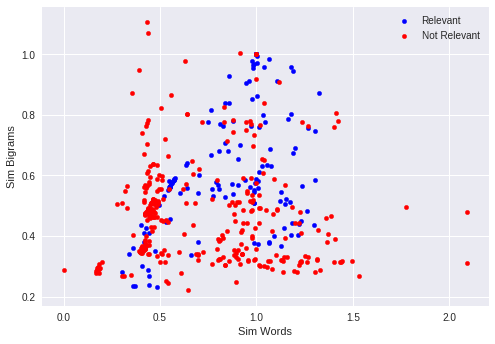

In [3]:
ax = relevant_df.plot.scatter(x = 'Sim Words', y = 'Sim Bigrams', color='Blue', label='Relevant')
not_relevant_df.plot.scatter(x = 'Sim Words', y = 'Sim Bigrams', color='Red', label='Not Relevant', ax=ax)

## Prediction of Relevance
Training the results using logistic regression (Géron 2017, pp. 136-140). 

### Using only BM25 with Bigrams
Try with only bigram based BM25 to begin with to see how predicted classifications vary with only one parameter.

In [18]:
from sklearn.linear_model import LogisticRegression

# Train
X = relevance_df["Sim Bigrams"]
X = X[:, np.newaxis]
y = relevance_df["Relevant"]
model = LogisticRegression()
model.fit(X, y)
print("Intercept: ", model.intercept_)
print("Coeficient: ", model.coef_)

Intercept:  [-2.41709632]
Coeficient:  [[3.01341748]]


Text(0,0.5,'Probability')

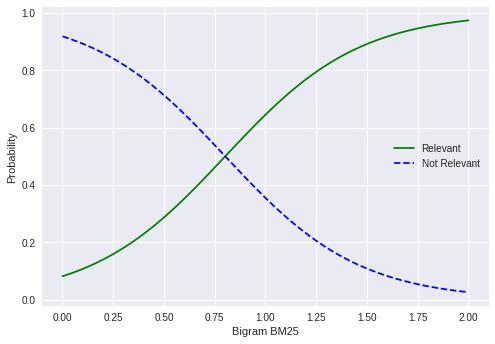

In [15]:
# Plot results
X_p = np.linspace(0, 2, 1000).reshape(-1, 1)
y_p = model.predict_proba(X_p)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_p, y_p[:, 1], "g-", label="Relevant")
ax.plot(X_p, y_p[:, 0], "b--", label="Not Relevant")
ax.legend(loc = "best")
#ax.set_title("Predicted Probability with Bigram BM25")
ax.set_xlabel("Bigram BM25")
ax.set_ylabel("Probability")

In [19]:
# Validate the decision boundary using formula from (Agresti 2013, p. 120)

from math import exp

a = model.intercept_
b = model.coef_[0]
x = 0.8
pi = exp(a + b * x) / (1 + exp(a + b * x))
print("Probability: {:3.2f}".format(pi))

Probability: 0.50


### Prediction with Multiple Vector Space Parameters
Train a logistic regression model with relevance data using BM25 for both individual words and bigrams and bit vector dot products for words.

In [20]:
X1 = relevance_df["Sim Words"]
X2 = relevance_df["Sim Bigrams"]
X3 = relevance_df["Bit Vector"]
X = np.array([X1, X2, X3], np.float32)
X = np.transpose(X)
y = relevance_df["Relevant"]
model = LogisticRegression()
model.fit(X, y)
print("Intercept: ", model.intercept_)
print("Coefficients: ", model.coef_)

Intercept:  [-4.74962488]
Coefficients:  [[0.08002782 2.32382776 3.03980071]]


In [21]:
X_val = np.array([[1.0, 1.0, 1.0], [0.2, 0.2, 0.2]])
y_val = model.predict(X_val)
y_val

array([1, 0], dtype=uint32)

In [22]:
p = model.predict_proba(X_val)
p

array([[0.33313687, 0.66686313],
       [0.97493488, 0.02506512]])

In [22]:
# Calculate using multiplication
y_v = model.coef_.dot(X_val[0])
y_v

array([5.44365628])

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X)
confusion_matrix(y, y_pred)

array([[303,  23],
       [ 99,  47]])

In [32]:
from sklearn.metrics import classification_report

target_names = ["Not relevant", "Relevant"]
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not relevant       0.75      0.93      0.83       326
    Relevant       0.67      0.32      0.44       146

 avg / total       0.73      0.74      0.71       472



## References
1. Agresti, Alan 2013, *Categorical Data Analysis*, John Wiley & Sons.

2. Géron, Aurélien 2017, *Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*, Kindle ed., O’Reilly Media, Inc.

3. Robertson, Stephen and Hugo Zaragoza 2009, "The Probabilistic Relevance Framework: BM25 and Beyond", *Foundations and Trends in Information Retrieval*: Vol. 3: No. 4, pp 333-389. http://dx.doi.org/10.1561/1500000019.

4. Zhai, Chengxiang and Sean Massung 2016, *Text Data Management and Analysis: A Practical Introduction to Information Retrieval and Text Mining*, Association for Computing Machinery; Morgan & Claypool.
